In [1]:
import pandas as pd
from functools import partial
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
import torch
from transformers import AutoTokenizer

from scripts.config import Config
from scripts.dataset import MultimodalDataset, collate_fn, draw_item, get_data, train_transforms, val_transforms

d:\final\calories\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\final\calories\.venv\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


# Подготовка и анализ данных

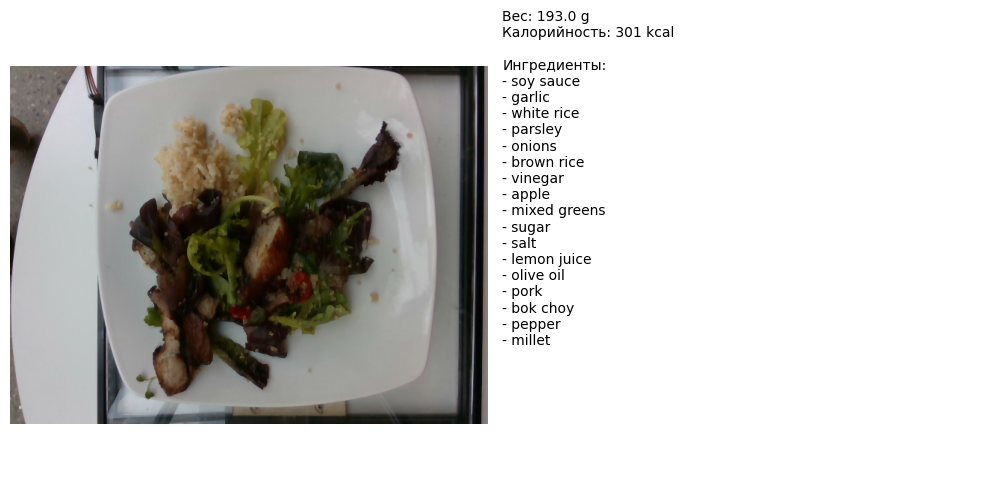

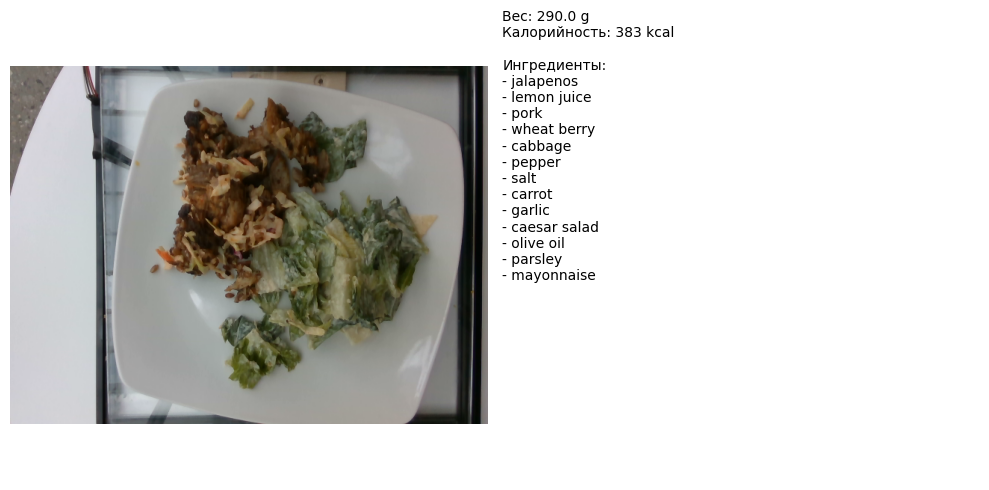

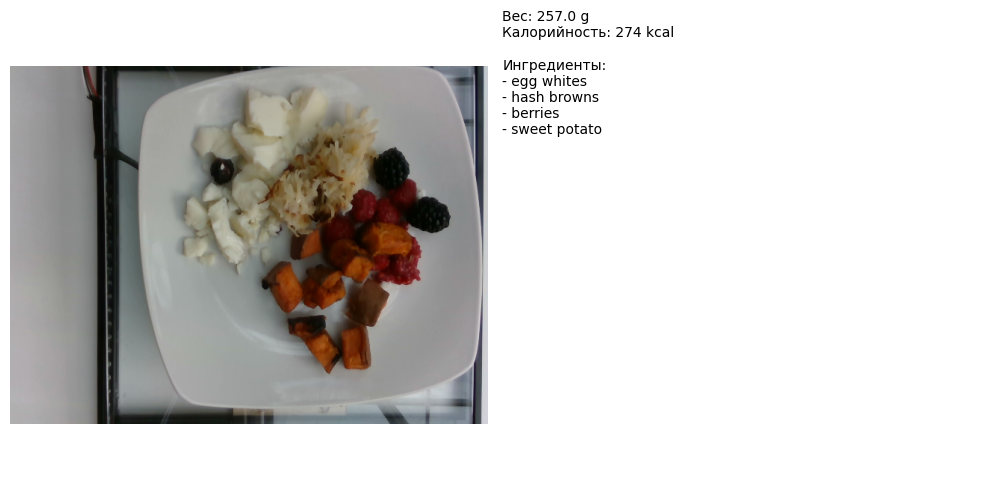

In [2]:
train_data, test_data = get_data("data/dish.csv")

ingredients = pd.read_csv("data/ingredients.csv")

data_example = MultimodalDataset(test_data, ingredients, transforms=None)

for i in range(3):
    draw_item(data_example[i])


Выводы по имеюшимся данным:
1) Основной информацией для определения калорийности является изображение блюда, масса и список ингредиентов. В данном проекте будет использоваться мультимодальная нейросетевая модель, которая обьединяет визуальный признак(изображение), текстовый(список ингредиенты), числовой(массу)
2) Для текстовой информации будет использоваться BERT-base-uncased, для визуальной ResNet-50
3) Для стабильности обучения у моделей будут замороженны большинство слоев, дообучены будут только последние блоки, проекционные слои, fusion-голова и регрессионная часть

Аугментация изображений:
1) Отражения по горизонтали, калорийность от этого не меняется, но модель становится устойчивее к вариациям ракурса
2) Имитация смещений и лёгких поворотов камеры при съёмке блюда
3) Приведение всех изображений к единому размеру, без обрезания самого блюда
4) Использование border_mode=cv2.BORDER_REFLECT_101 при паддинге и вращении для более естественного фона
5) Имитация разных условий освещения и цветовой температуры камеры, чтобы модель не переобучалась на конкретный свет/тон

Работа с текстом: формирование текстового входа как конкатенации ингредиентов в строку с фиксированной максимальной длиной токенов


Основная целевая метрика - MAE. На тестовом наборе необходимо будет получить значение < 50. В процессе обучения также будет учет метрики на обучении и валидации


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text_model = "bert-base-uncased"
image_model = 'tf_efficientnet_b0'

train_df, val_df = train_test_split(
    train_data,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)

train_dataset = MultimodalDataset(train_df, ingredients, transforms=train_transforms)
val_dataset = MultimodalDataset(val_df, ingredients, transforms=val_transforms)
test_dataset = MultimodalDataset(test_data, ingredients, transforms=val_transforms)

tokenizer = AutoTokenizer.from_pretrained(Config.TEXT_MODEL_NAME)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=partial(collate_fn, tokenizer=tokenizer),
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=partial(collate_fn, tokenizer=tokenizer),
    num_workers=4,
    pin_memory=True
)


# Объявление и обучение модели

In [ ]:
from scripts.utils import MultimodalCalorieRegressor, train_model

model = MultimodalCalorieRegressor(
    text_model_name=Config.TEXT_MODEL_NAME,
    image_model_name=Config.IMAGE_MODEL_NAME,
    emb_dim=Config.HIDDEN_DIM,
    hidden_dim=Config.HIDDEN_DIM,
    dropout=Config.DROPOUT
)

train_model(
    model,
    train_loader,
    val_loader,
    device=device,
    config=Config
)


Валидация эпоха 1: 100%|██████████| 18/18 [00:44<00:00,  2.48s/it]


Эпоха 1 | train_MAE: 141.18 | val_MAE: 109.54



Валидация эпоха 2: 100%|██████████| 18/18 [00:44<00:00,  2.47s/it]


Эпоха 2 | train_MAE: 86.26 | val_MAE: 74.24



Валидация эпоха 3: 100%|██████████| 18/18 [00:44<00:00,  2.47s/it]


Эпоха 3 | train_MAE: 75.25 | val_MAE: 65.72



Валидация эпоха 4: 100%|██████████| 18/18 [00:44<00:00,  2.50s/it]


Эпоха 4 | train_MAE: 68.01 | val_MAE: 75.76



Валидация эпоха 5: 100%|██████████| 18/18 [00:44<00:00,  2.47s/it]


Эпоха 5 | train_MAE: 61.15 | val_MAE: 56.20



Валидация эпоха 6: 100%|██████████| 18/18 [00:44<00:00,  2.47s/it]


Эпоха 6 | train_MAE: 57.21 | val_MAE: 47.79



Валидация эпоха 7: 100%|██████████| 18/18 [00:45<00:00,  2.50s/it]


Эпоха 7 | train_MAE: 56.29 | val_MAE: 47.31



Валидация эпоха 8: 100%|██████████| 18/18 [00:45<00:00,  2.53s/it]


Эпоха 8 | train_MAE: 54.87 | val_MAE: 46.11



Валидация эпоха 9: 100%|██████████| 18/18 [00:48<00:00,  2.68s/it]


Эпоха 9 | train_MAE: 53.16 | val_MAE: 51.36



Валидация эпоха 10: 100%|██████████| 18/18 [00:44<00:00,  2.49s/it]


Эпоха 10 | train_MAE: 49.76 | val_MAE: 46.73



Валидация эпоха 11: 100%|██████████| 18/18 [00:45<00:00,  2.51s/it]


Эпоха 11 | train_MAE: 50.76 | val_MAE: 46.14



Валидация эпоха 12: 100%|██████████| 18/18 [00:44<00:00,  2.48s/it]


Эпоха 12 | train_MAE: 48.43 | val_MAE: 42.09



Валидация эпоха 13: 100%|██████████| 18/18 [00:44<00:00,  2.47s/it]


Эпоха 13 | train_MAE: 50.25 | val_MAE: 41.66



Валидация эпоха 14: 100%|██████████| 18/18 [00:44<00:00,  2.47s/it]


Эпоха 14 | train_MAE: 46.62 | val_MAE: 45.89



Валидация эпоха 15: 100%|██████████| 18/18 [00:45<00:00,  2.51s/it]


Эпоха 15 | train_MAE: 47.34 | val_MAE: 48.39



Валидация эпоха 16: 100%|██████████| 18/18 [00:44<00:00,  2.50s/it]


Эпоха 16 | train_MAE: 46.25 | val_MAE: 41.95



Валидация эпоха 17: 100%|██████████| 18/18 [00:45<00:00,  2.50s/it]


Эпоха 17 | train_MAE: 43.51 | val_MAE: 46.95



Валидация эпоха 18: 100%|██████████| 18/18 [00:44<00:00,  2.48s/it]


Эпоха 18 | train_MAE: 43.45 | val_MAE: 38.47



Валидация эпоха 19: 100%|██████████| 18/18 [00:44<00:00,  2.47s/it]


Эпоха 19 | train_MAE: 40.54 | val_MAE: 41.30



Валидация эпоха 20: 100%|██████████| 18/18 [00:44<00:00,  2.46s/it]


Эпоха 20 | train_MAE: 42.20 | val_MAE: 46.44



Валидация эпоха 21: 100%|██████████| 18/18 [00:44<00:00,  2.46s/it]


Эпоха 21 | train_MAE: 40.33 | val_MAE: 38.46



Валидация эпоха 22: 100%|██████████| 18/18 [00:44<00:00,  2.47s/it]


Эпоха 22 | train_MAE: 41.48 | val_MAE: 38.93



Валидация эпоха 23: 100%|██████████| 18/18 [00:44<00:00,  2.46s/it]


Эпоха 23 | train_MAE: 39.94 | val_MAE: 47.74



Валидация эпоха 24: 100%|██████████| 18/18 [00:45<00:00,  2.51s/it]


Эпоха 24 | train_MAE: 41.42 | val_MAE: 36.58



Валидация эпоха 25: 100%|██████████| 18/18 [00:44<00:00,  2.49s/it]


Эпоха 25 | train_MAE: 39.68 | val_MAE: 36.28



Валидация эпоха 26: 100%|██████████| 18/18 [00:44<00:00,  2.48s/it]


Эпоха 26 | train_MAE: 39.50 | val_MAE: 36.64



Валидация эпоха 27: 100%|██████████| 18/18 [00:44<00:00,  2.48s/it]


Эпоха 27 | train_MAE: 38.28 | val_MAE: 40.64



Валидация эпоха 28: 100%|██████████| 18/18 [00:44<00:00,  2.48s/it]


Эпоха 28 | train_MAE: 38.09 | val_MAE: 37.47



Валидация эпоха 29: 100%|██████████| 18/18 [00:44<00:00,  2.46s/it]


Эпоха 29 | train_MAE: 37.69 | val_MAE: 36.91



Валидация эпоха 30: 100%|██████████| 18/18 [00:44<00:00,  2.49s/it]


Эпоха 30 | train_MAE: 37.11 | val_MAE: 36.28



# Оценка качества и выводы

In [7]:
from scripts.utils import evaluate
from scripts.utils import MultimodalCalorieRegressor

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=partial(collate_fn, tokenizer=tokenizer),
    num_workers=4,
    pin_memory=True
)
model_check_point = MultimodalCalorieRegressor(
    text_model_name=Config.TEXT_MODEL_NAME,
    image_model_name=Config.IMAGE_MODEL_NAME,
    emb_dim=Config.HIDDEN_DIM,
    hidden_dim=Config.HIDDEN_DIM,
    dropout=Config.DROPOUT
)
checkpoint = torch.load(Config.SAVE_PATH, map_location=device)
model_check_point.to(device)
print(f"Загрузка модели(эпоха - {checkpoint["epoch"]}, показание MAE на валидации - {checkpoint["val_mae"]:0.2f})")
model_check_point.load_state_dict(checkpoint["model_state_dict"])
test_mae, errors_info = evaluate(model_check_point, test_loader, epoch=0, device=device, collect_errors=True)
print(f"Test_MAE: {test_mae:.2f}")

Загрузка модели(эпоха - 25, показание MAE на валидации - 36.28)


Валидация эпоха 0: 100%|██████████| 16/16 [00:33<00:00,  2.09s/it]


Test_MAE: 46.66


Визуализация 5 самых тяжелых примеров

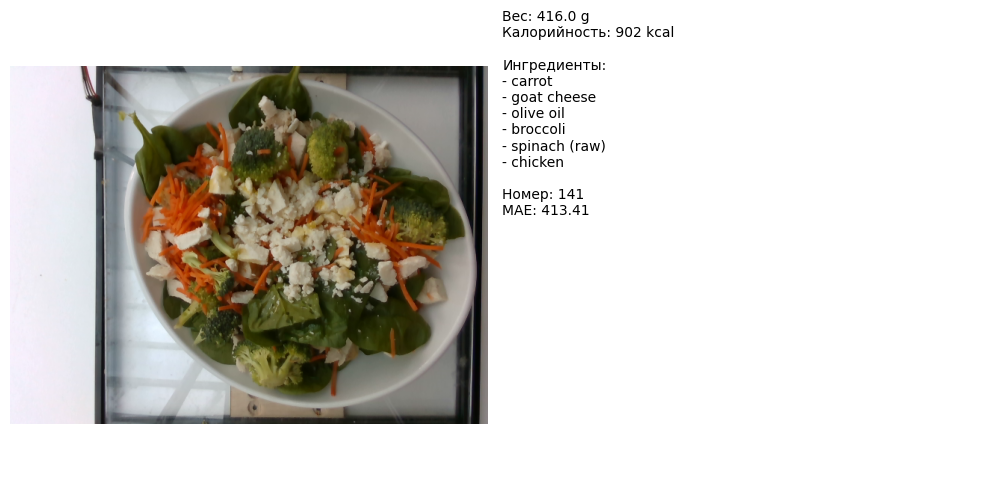

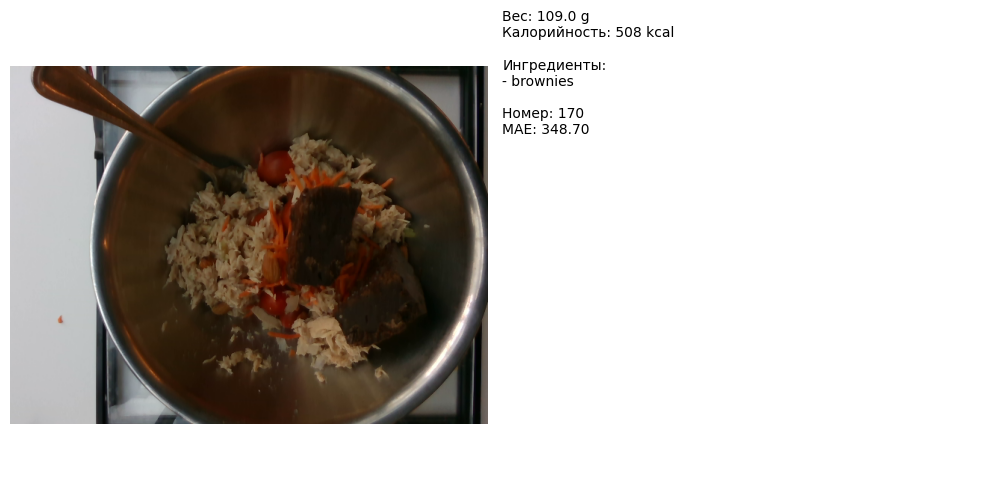

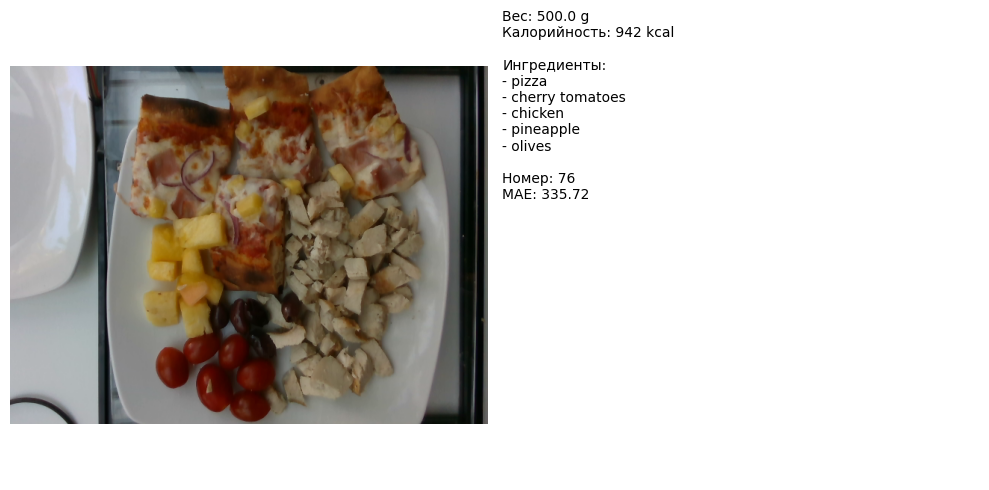

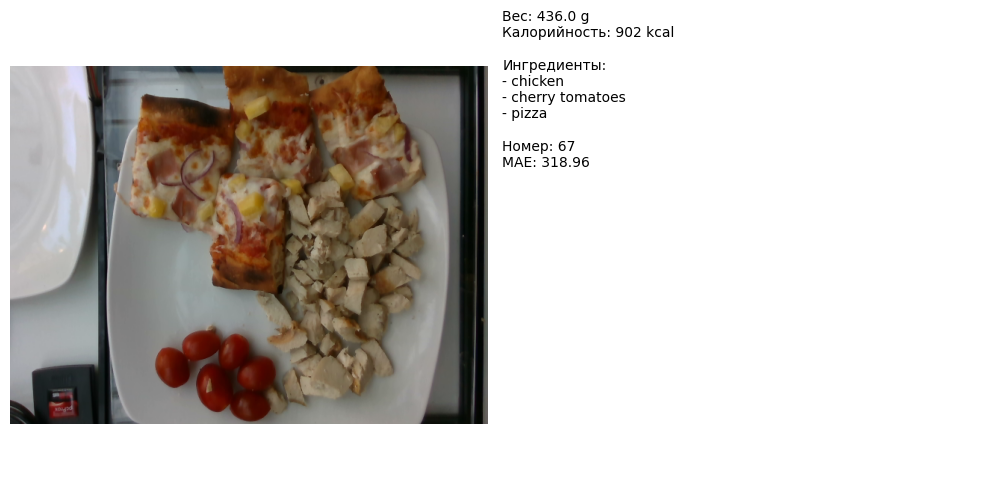

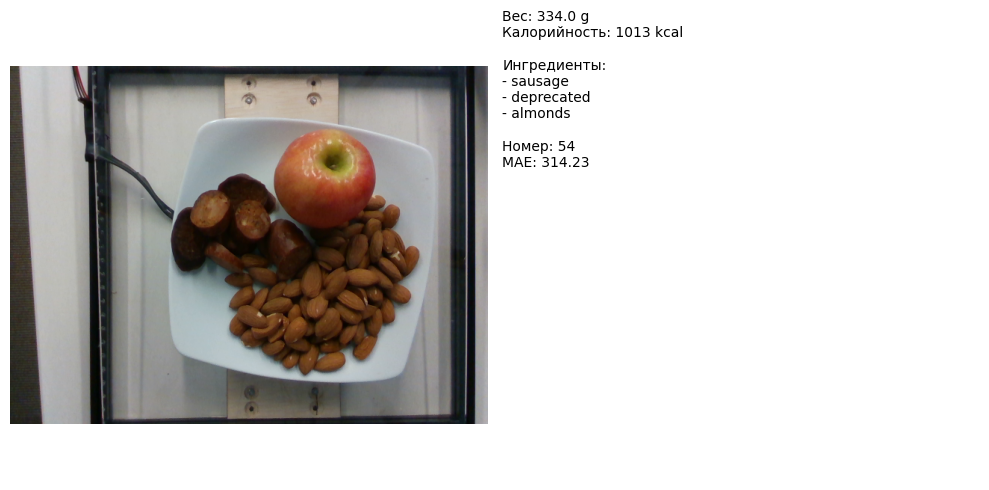

In [5]:
from scripts.dataset import get_by_dish_id
for i in range(5):
    idx, sample = get_by_dish_id(data_example, errors_info[i]['dish_id'])
    draw_item(sample, idx, f"{errors_info[i]['error']:.2f}")

При разборе пяти примеров, где модель ошиблась сильнее всего, стало видно, что дело часто не в самой модели, а в особенностях данных.

1) Скрытые калорийные компоненты (масло)
В блюде №141 тарелка полностью заполнена овощами (416г), а по аннотации калорийность - 902 ккал. На фото масло не видно, но, судя по таргету, именно оно даёт основную часть калорий. Модель же видит только овощи и их массу, поэтому логично занижает прогноз: большая часть калорий просто не отражена ни на изображении, ни в описании.
То же самое можно сказать и про  №76 и №67. У них в составе есть пицца, а оно занимает мало места, но обычно очень калорийна за счет состава

2) Неполное описание ингредиентов, лишние артефакты на изображении
Для блюда №170 масса небольшая (109г), при этом калорийность - 508 ккал. На изображении видно ложку и как минимум два разных компонента, но в данных указан только один ингредиент. В итоге модель опирается на неполную информацию, из-за чего может сильно ошибаеться в предсказании.

3) Нетипичные таргеты (непривычное соотношение массы и калорийности)
В примере с блюдом №54 масса составляет 334г, а калорийность - 1013 ккал. На изображении видно яблоко и немного орехов, визуально порция не выглядит очень тяжёлой. Такое соотношение массы и калорийности выбивается из общих закономерностей в данных, и модель на подобных примерах тоже начинает сильно ошибаться.

В целом эти наблюдения показывают, что большие ошибки модели часто связаны не с её устройством, а с качеством и полнотой данных: скрытыми калорийными компонентами, неполным списком ингредиентов, расхождениями между изображением и описанием, а также нетипичными или потенциально ошибочными значениями таргета.